In [1]:
# 基本的なライブラリ
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# パイプライン
from imblearn.pipeline import Pipeline

# サンプリング
from imblearn.over_sampling import SMOTE

# モデル
from sksurv.ensemble import RandomSurvivalForest

# 評価指標
from sklearn.metrics import mean_squared_error

# チューニング
import optuna

# local libraries
import config
import functions

SEED = config.SEED
functions.fix_seed(SEED)

# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

/home/breast-cancer-analytics/notebooks/functions.py:185: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train: pd.Series(),
/home/breast-cancer-analytics/notebooks/functions.py:187: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val: pd.Series(),


# 最適化

分類器を学習させ、パラメータのチューニングを行い、高い予測精度を目指す。

### LogisticRegression

0it [00:00, ?it/s]

--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/1000 [00:00<?, ?it/s]

{'penalty': 'l1', 'C': 42451.75908066813}
0.375


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
LogisticRegression,0.898148,0.5,0.898148,0.375


subgroup:  Her2


  0%|          | 0/1000 [00:00<?, ?it/s]

{'penalty': 'l1', 'C': 42451.75908066813}
0.4


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
LogisticRegression,0.985075,0.727273,0.985075,0.4


subgroup:  LumA


  0%|          | 0/1000 [00:00<?, ?it/s]

{'penalty': 'l1', 'C': 42451.75908066813}
0.380952380952381


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
LogisticRegression,0.885417,0.35,0.885417,0.380952


1it [00:11, 11.10s/it]

subgroup:  claudin-low
pkl file does not exist
train data does not exist
subgroup:  Basal
pkl file does not exist
train data does not exist
subgroup:  Normal
pkl file does not exist
train data does not exist
subgroup:  NC
pkl file does not exist
train data does not exist


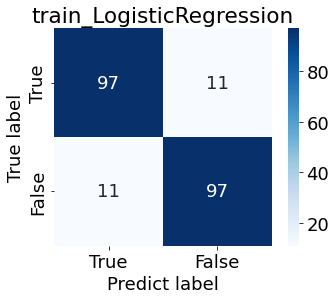

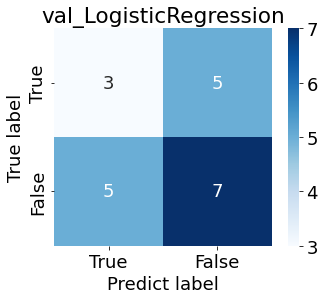

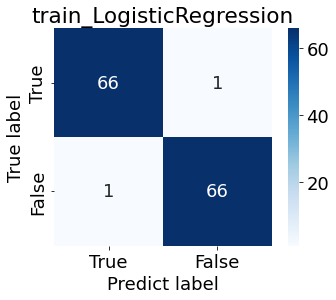

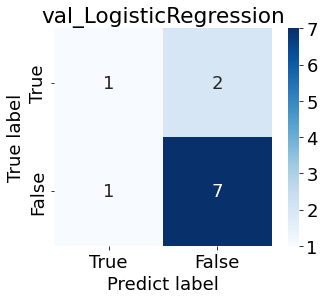

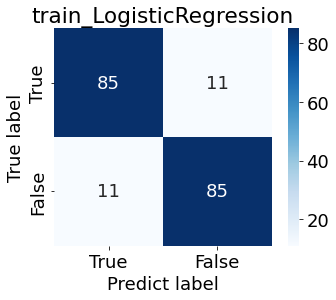

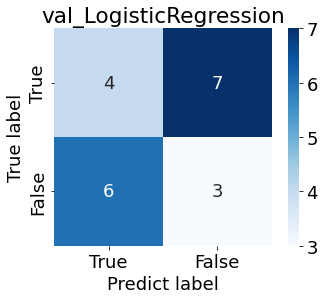

In [3]:
def objective(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-5, 1e5),
        "max_iter": 1000,
        "solver": "liblinear",
        "class_weight": "balanced",
        "random_state": SEED,
    }

    clf = LogisticRegression(**params)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return f1_score(y_val, y_val_pred)


# 層別化する特徴量
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    #    "THREEGENE",
]
# 遺伝子発現量以外の特徴量を削除
drop_columns = [
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
]


# 実施したい学習の定義
model_order_dicts = [
    {
        "model_name": "RandomSurvivalForest",
        "preprocess_name": "preprocess4numeric_1",
        "model_order": [
            (
                "RandomSurvivalForest",
                RandomSurvivalForest(),
            ),
        ],
    },
]

for subgroup_column in subgroup_columns:  # 各サブグループへの適用
    print("##########" * 10)
    print("subgroup_column: ", subgroup_column)
    for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
        print("==========" * 10)
        print("subgroup: ", subgroup)
        for model_order_dict in model_order_dicts:
            print(".........." * 10)
            print("model_order_dict name: ", model_order_dict["model_name"])
            input_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
            )
            """
            output_file_path = "./{0}/{1}/{2}/{3}".format(
                config.FIGURES_TUNING_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["model_name"],
            )"""
            

            # tuning
            clf = RandomSurvivalForest()

            X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
            X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(
                direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
            )
            study.optimize(objective, n_trials=1000, show_progress_bar=True)

            print(study.best_params)
            print(study.best_value)

            # save params
            save_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            functions.make_dir(save_file_path)
            save_file_name_paramas = "/params_{0}.pkl".format(subgroup)
            save_file_name_value = "/value_{0}.pkl".format(subgroup)
            functions.pickle_dump(
                study.best_params, save_file_path + save_file_name_paramas
            )
            functions.pickle_dump(
                study.best_value, save_file_path + save_file_name_value
            )

            # use params
            params = {
                "penalty": study.best_params["penalty"],
                "C": study.best_params["C"],
                "max_iter": 1000,
                "solver": "liblinear",
                "class_weight": "balanced",
                "random_state": SEED,
            }
            clf.set_params(**params)
            clf.fit(X_train, y_train)
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    classifiers=[clf],
                    plot=True,
                )
            )